In [46]:
import numpy as np
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

from phystem.systems.ring import utils

def voro_edges(pos: np.ndarray):
    '''Ids que formam os links calculados a partir do diagrama de Voronoi.
    
    Parâmetros:
        pos:
            Array com as posições. Seu shape deve ser 
                (N, 2) 
            em que N é o número de pontos. Descrição:
                pos[i, 0] -> Posição x do i-ésimo ponto
                pos[i, 1] -> Posição y do i-ésimo ponto
    
    Retorno:
        ids_edges:
            Ids dos pontos que formam um link. Seu shape é (M, 2), em que M é o 
            número de links. Cada link é uma conexão entre dois
            pontos em `pos`

            ids_edges[i, 0] -> Id do ponto em `pos` que inicia o i-ésimo link 
            ids_edges[i, 1] -> Id do ponto em `pos` que finaliza o i-ésimo link 

            Logo o vetor que representa o i-ésimo link é

                id1, id2 = ids_edges[i]
                link_i = pos[id2] - pos[id1]
    '''
    vor = Voronoi(pos) # create Voronoi diagram
    points_adj = vor.ridge_points
    edges = np.sort(points_adj, axis=-1)
    ids_edges = np.array(sorted((a,b) for a,b in edges.astype(int)))
    return ids_edges

def calc_edges(cm, ring_diameter, k=1):
    '''Ids que formam os links nos pontos em `cm`, de acordo
    com o diagrama de Voronoi, com a condição de que o comprimento do
    link seja menor do que `rin_diameter*k`.
    O shape de cm deve ser (N, 2), em que N é o número de pontos.
    '''
    edges = voro_edges(cm)
    edge_dist = cm[edges[:,0]] - cm[edges[:,1]]
    edge_dist = np.sqrt(np.square(edge_dist).sum(axis=1))
    return edges[edge_dist<ring_diameter*k]

def neighbors_all(links, n):
    neighs = [[] for _ in range(n)]
    for l in links:
        neighs[l[0]].append(l[1])
        neighs[l[1]].append(l[0])
    return neighs

def neighbors_list(links, pos_list):
    neighs = []
    for pid in pos_list:
        neighs_ids_1 = links[links[:, 0] == pid][:,1]
        neighs_ids_2 = links[links[:, 1] == pid][:,0]
        neighs_ids = np.concatenate([neighs_ids_1, neighs_ids_2])
        neighs.append(neighs_ids)
    return neighs

def load_configs(path):
    with open(Path(path)/"config.yaml") as f:
        cfgs = yaml.unsafe_load(f)
    return cfgs

In [6]:
root_dir = "../flux_creation_rate/data/low_adh_align/autosave"

pos = np.load(Path(root_dir)/"pos.npy")
cfgs = load_configs(root_dir)
cm = utils.get_cm(pos)

mask = (cm[:, 0] > -200) & ((cm[:, 0] < -100))
cm = cm[mask]

751


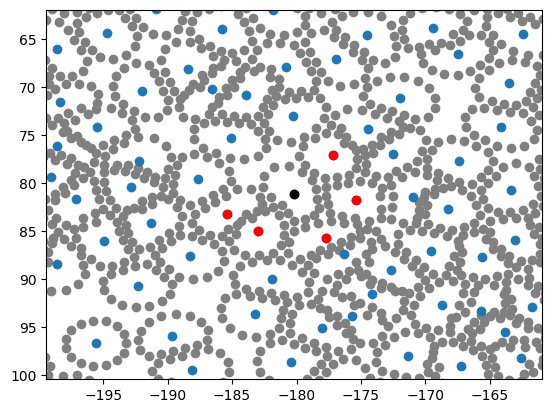

In [54]:
# cm = np.array([
#     [0, 0],
#     [1, 0],
#     [0, 1],
#     [1, 1],
# ])

d = utils.get_ring_radius(
    cfgs["dynamic_cfg"].diameter, cfgs["creator_cfg"].num_p) * 2

links = calc_edges(cm, d, 1.3)

ring_id = np.random.randint(0, cm.shape[0])
print(ring_id)
# ring_id = 837

# neighs_ids_1 = links[links[:, 0] == ring_id][:,1]
# neighs_ids_2 = links[links[:, 1] == ring_id][:,0]
# neighs_ids = np.concatenate([neighs_ids_1, neighs_ids_2])

# neighs_ids = neighbors_all(links, cm.size)[ring_id]
neighs_ids = neighbors_list(links, np.array([ring_id]))[0]

x, y = cm[ring_id]
plt.xlim(x-4*d, x+4*d)
plt.ylim(y+4*d, y-4*d)

plt.scatter(*utils.pos_to_scatter(pos), c="gray")

plt.scatter(*cm.T)
plt.scatter(*cm[ring_id], c="black")
plt.scatter(*cm[neighs_ids].T, c="red")